In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import jetsimpy
from functools import partial
import scipy.integrate as spi

In [3]:
data_XRT = pd.read_excel('xrt.xlsx')
data_BAT = pd.read_excel('bat.xlsx')
data_XRT_lc = pd.read_excel('xrt_lightcurve.xlsx')

data_XRT_lc = data_XRT_lc.iloc[::12]
data_XRT = data_XRT.iloc[::12]

#Frequencies
nu1_xrt = 7.25e16 #0.3 kev
nu2_xrt = 2.42e18 #10 kev

In [15]:
data_XRT_lc

,time,err_time,err_timen,flux(cgs),err_flux,err_fluxn,flux_integrated
0,68.0193,0.3559,-0.3024,8.156439e-08,1.164084e-08,-2.184807e-08,7.130632e-07
12,75.5647,0.2348,-0.3043,6.300054e-08,1.030186e-08,-1.795471e-08,6.795379e-07
24,83.0105,0.3681,-0.2973,5.340458e-08,9.641188e-09,-1.504882e-08,6.488566e-07
36,90.6722,0.4047,-0.3425,4.680244e-08,7.516491e-09,-1.308619e-08,6.176007e-07
48,98.6598,0.3805,-0.3507,4.854032e-08,8.146415e-09,-1.263156e-08,5.869983e-07
...,...,...,...,...,...,...,...
1020,51573.8970,64.8290,-58.0300,1.394710e-11,3.182681e-12,-3.182681e-12,1.255690e-10
1032,62881.1050,68.0220,-112.5050,1.039489e-11,2.279709e-12,-2.279709e-12,8.086025e-11
1044,74934.0800,267.1350,-352.1590,3.009867e-12,7.601543e-13,-7.601543e-13,5.319607e-11
1056,107663.0570,116.1030,-94.5120,6.422418e-12,1.668505e-12,-1.668505e-12,2.334366e-11


In [24]:
P = dict(
    Eiso = 3.6e54,        # Isotropic equivalent energy
    lf = 526,           # Lorentz factor
    theta_c = np.radians(0.8),      # half opening angle
    n0 = 0.05,             # ism number density
    A = 0,              # wind number density amplitude
    eps_e = 0.1,        # epsilon_e
    eps_b = 3.5e-3,       # epsilon_b
    p = 2.25,           # electron power index
    theta_v = 0,      # viewing angle (rad)
    d = 2390,         # distance (Mpc)
    z = 0.4245,            # redshift
)

art_par = dict(
    Eiso = np.double(10**53.49),        # Isotropic equivalent energy #
    lf = 526,           # Lorentz factor
    theta_c = np.radians(5),      # half opening angle
    n0 = np.double(10**-0.94),    # ism number density
    A = 0.1,              # wind number density amplitude
    eps_e = np.double(10**-1.05),        # epsilon_e
    eps_b = np.double(10**-3.48),       # epsilon_b
    p = 2.4,           # electron power index
    theta_v = np.radians(0),      # viewing angle (rad)
    d =  2300,         # distance (Mpc)
    z = 0.4245,            # redshift
)

In [43]:
def flux_grb(parameters,nu,time):

    jet_gauss = jetsimpy.Jet(
    jetsimpy.Gaussian(parameters["theta_c"], parameters["Eiso"], lf0=parameters["lf"]),    # jet profile
    parameters["A"],                        # wind number density scale
    parameters["n0"],                       # ism number density scale
    spread=False,                  # w/wo spreading effect 
)
    flux = jet_gauss.FluxDensity(
        time,  
        nu,     
        parameters,           
    )
    return flux  

def flux_integrated(parameters,data_df,freq1,freq2,time,key):
    frequencies = np.linspace(freq1,freq2,20)
    diff = frequencies[1]-frequencies[0]
    
    fluxes = dict()
    
    for i,j in data_df.iterrows():
        flux_time = list()
        for freq in frequencies:
            flux_freq = flux_grb(parameters,freq,j[time])
            flux_time.append(flux_freq*diff)
        data_df.at[i, f'flux_integrated_{key}'] = np.sum(flux_time)*1e-26

    return data_df['flux_integrated']

def hao_flux(parameters,x,nu1,nu2):
    jet_gauss = jetsimpy.Jet(
        jetsimpy.Gaussian(parameters['theta_c'], parameters['Eiso'], parameters['lf']),
        parameters['A'],
        parameters['n0'],
        spread=False
    )

    # Get flux density from model
    model = jet_gauss.Flux(x, nu1, nu2, parameters)

    return model

In [44]:
foison_par_mycode = flux_integrated(P,data_XRT_lc,nu1_xrt,nu2_xrt,'time','foison')
foison_par_haocode = hao_flux(P,data_XRT_lc['time'],nu1_xrt,nu2_xrt)

art_par_mycode = flux_integrated(art_par,data_XRT_lc,nu1_xrt,nu2_xrt,'time','art')
art_par_haocode = hao_flux(art_par,data_XRT_lc['time'],nu1_xrt,nu2_xrt)

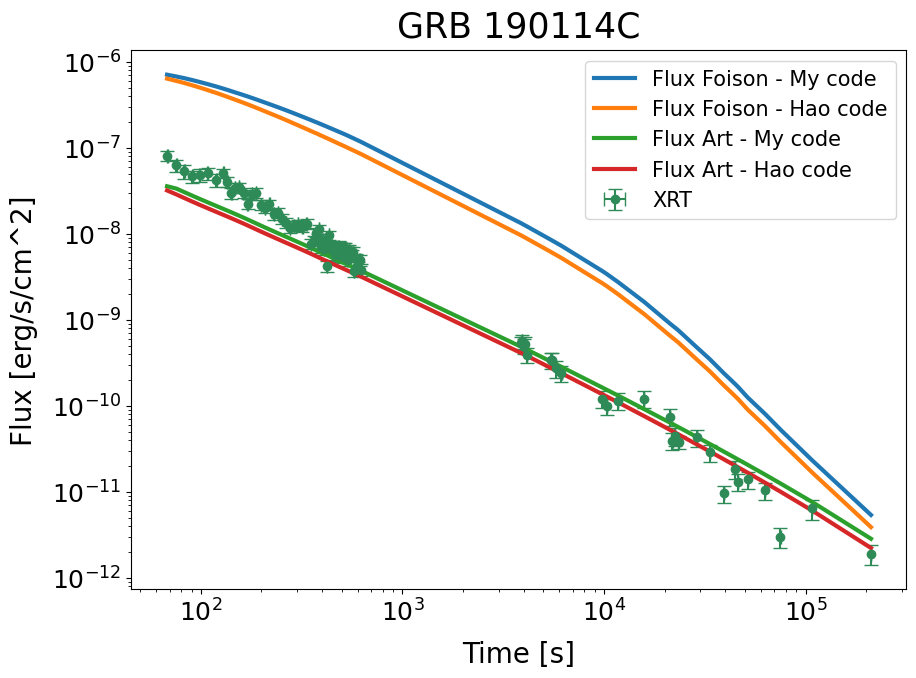

In [46]:
plt.figure(figsize=(10,7))

plt.errorbar(data_XRT_lc['time'], data_XRT_lc['flux(cgs)'], xerr = data_XRT_lc['err_time'], yerr=data_XRT_lc['err_flux'], fmt='o', label='XRT', capsize=5, color = 'seagreen')
plt.plot(data_XRT_lc['time'], data_XRT_lc['flux_integrated_foison'], lw=3,label='Flux Foison - My code')
plt.plot(data_XRT_lc['time'], foison_par_haocode, lw=3,label='Flux Foison - Hao code')
plt.plot(data_XRT_lc['time'], data_XRT_lc['flux_integrated_art'], lw=3,label='Flux Art - My code')
plt.plot(data_XRT_lc['time'], art_par_haocode, lw=3,label='Flux Art - Hao code')

plt.title('GRB 190114C',size=25,pad=10)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Time [s]",size=20,labelpad=10)
plt.ylabel("Flux [erg/s/cm^2]",size=20,labelpad=10)
plt.legend(fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.show()